# Import Required Libaries

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from keras.utils import normalize
from keras.models import model_from_json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from keras.applications.resnet_v2 import ResNet101V2

In [ ]:
classLabels=['benign', 'malignant']
n_classes = len(classLabels)
SIZE = 224
path_US = '/content/drive/MyDrive/Datasets/Dataset-B/images/*'
path_fused = '/content/drive/MyDrive/Datasets/Dataset-B/Fused/*'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Function Utilities

In [ ]:
# ResNet101V2 Model
def create_model(X_train, y_train, x_test, y_test, SIZE, model_type):
  model =  model_type(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

  for layer in model.layers:
    layer.trainable = False
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = tf.keras.layers.Dense(512, activation='relu')(x)

  # Add a dropout rate of 0.3
  x = tf.keras.layers.Dropout(0.3)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(120, activation='relu')(x)

  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1 , activation='sigmoid')(x)

  model = tf.keras.Model(model.input, x)


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print("Model successfully compiled")

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  csv_logger = tf.keras.callbacks.CSVLogger('training.log')

  # Data Augmentation

  datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

  datagen.fit(X_train)

  start = datetime.now()

  history = model.fit(datagen.flow(X_train,y_train), epochs=125,verbose=1, validation_data=(x_test,y_test), callbacks=[es,csv_logger])

  stop = datetime.now()

  training_time = stop - start

  print('Model training time is :', training_time)

  plot_history(history)

  #save to disk

  model_json = model.to_json()
  model_name = model_type + "_model.h5"
  json_name = model_type + "_model.json"

  with open(json_name, 'w') as json_file:
    json_file.write(model_json)
  model.save_weights(model_name)

  return history

In [ ]:
# Plot training history
def plot_history(history=None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1)
    plt.figure(figsize = (20,7))

    plt.subplot(1,3,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,3,2)
    plt.plot(epochsn, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [ ]:
# One-Hot Encoding
def one_hot_encode(x):
    #Encode labels from text to integers.
    le = preprocessing.LabelEncoder()

    le.fit(x)

    encoded = le.transform(x)
    return encoded

In [ ]:
# Load Dataset
def load_data(SIZE, path):
    train_images = []
    # pr_train_images = []
    train_labels = []

    for directory_path in glob.glob(path):
        label = directory_path.split("/")[-1]
        #print(label)
        for img_path in glob.glob(os.path.join(directory_path, "*.png")):
            #print(img_path)
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE, SIZE))
            train_images.append(img)
            train_labels.append(label)
    #Convert lists to arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    # pr_train_images = np.array(pr_train_images)
    return train_images, train_labels

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    #rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    #M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    #y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

In [ ]:
def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    #y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    #print(len(x_train))
    for idx in range(len(x_train)):
        #print("Augmented image ",idx)
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
# Load CNN model for feature extraction
def load_cnn_model(path_jason, path_model):
	# load json and create model
	json_file = open(path_jason, 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	loaded_model = model_from_json(loaded_model_json)
	# load weights into new model
	loaded_model.load_weights(path_model)
	return loaded_model

In [ ]:
# Get feature vector
def get_feature_layer(model, data):
	total_layers = len(model.layers)

	fl_index = total_layers-2
	feature_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=fl_index).output)

	feature_layer_output = feature_layer_model.predict(data)

	rows,cols = np.shape(feature_layer_output)

	print("Number of features extracted: ",cols)

	return feature_layer_output

In [ ]:
# Initialize the multilayer perceptron classifier
mlp = MLPClassifier()

# Initialize the k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Initialize the random forest classifier
rf = RandomForestClassifier()

# Initialize the gradient boosting classifier
gb = GradientBoostingClassifier()

# Create a voting classifier with weights for the individual classifiers
clf = VotingClassifier(
    estimators=[('mlp', mlp), ('knn', knn), ('rf', rf), ('gb', gb)],
    weights=[1, 1, 2, 1], voting='soft')


classifiers = ['RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','MLP','GradientBoosting', 'Proposed']
models = [RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1),
          GradientBoostingClassifier(random_state=0),
          clf]

In [ ]:
# Score of classifiers
def acc_score(X_train,X_test,Y_train,y_true):
    Score = pd.DataFrame({"Classifier":classifiers})

    acc = []
    pr = []
    re = []
    f1 = []
    auc = []
    sen = []
    spec = []

    for i in models:
        model = i
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)

        # Compute accuracy, precision, and recall
        acc.append(metrics.accuracy_score(y_true, y_pred))
        pr.append(metrics.precision_score(y_true, y_pred))
        re.append(metrics.recall_score(y_true, y_pred))
        f1.append(metrics.f1_score(y_true, y_pred))

        # Compute area under the ROC curve
        area = metrics.roc_auc_score(y_true, model.predict_proba(X_test)[:,1])
        auc.append(area)

        # Compute sensitivity and specificity
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        true_positive = confusion_matrix[1][1]
        false_negative = confusion_matrix[1][0]
        true_negative = confusion_matrix[0][0]
        false_positive = confusion_matrix[0][1]
        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        sen.append(sensitivity)
        spec.append(specificity)

    Score["Accuracy"] = acc
    Score["Precision"] = pr
    Score["Recall"] = re
    Score["Sensitivity"] = sen
    Score["Specificity"] = spec
    Score["F1_Score"] = f1
    Score["ROC_AUC"] = auc


    Score.sort_values(by="F1_Score", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

In [ ]:
def evaluate_performance(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='micro')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='micro')

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='micro')

    # Calculate specificity
    cm = confusion_matrix(y_true, y_pred)

    true_positive = cm[1][1]
    false_negative = cm[1][0]
    true_negative = cm[0][0]
    false_positive = cm[0][1]
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred)

    return accuracy, precision, recall, specificity, f1, roc_auc

In [ ]:
def visualize(train_images, test_images ):
  # Load the train and test images


  # Create a figure with subplots
  fig, axes = plt.subplots(nrows=1, ncols=2)

  # Draw the first train image on the first subplot
  axes[0].imshow(train_images[0], cmap='gray')
  axes[0].set_title('Train Image')

  # Draw the first test image on the second subplot
  axes[1].imshow(test_images[0], cmap='gray')
  axes[1].set_title('Test Image')

  # Show the plot
  plt.show()

In [ ]:
def prob2binary(y_pred):
  # Set the threshold value
  threshold = 0.5

  # Convert the continuous prediction values into discrete class labels
  y_pred_class = np.where(y_pred > threshold, 1, 0)
  return y_pred_class


# Non-Fused Dataset B

## Load Data

In [ ]:
# Load Training Data
X_US, Y_US = load_data(SIZE, path_US)
print('Non Fused Dataset A loaded')
X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X_US, Y_US, test_size=0.3, random_state=42)

Non Fused Dataset A loaded


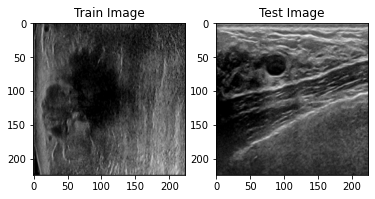

In [ ]:
#Visulaize the images
visualize(X_train_US, X_test_US)

In [ ]:
# Pre-process data
X_train_US = normalize(X_train_US, axis=1)
y_train_US = one_hot_encode(y_train_US)


test_data = normalize(X_test_US, axis=1)
test_labels = one_hot_encode(y_test_US)

In [ ]:
# Apply augmentation
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train_US, y_train_US)

# Combine the whole training data

data = np.concatenate([X_train_US, x_rotated, x_flipped])
labels = np.concatenate([y_train_US, y_rotated, y_flipped])

print('Shape of X_train:', np.shape(data))
print('Shape of y_train:', np.shape(labels))

Shape of X_train: (453, 224, 224, 3)
Shape of y_train: (453,)


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
print('Shape of training data:', np.shape(train_data))
print('Shape of training labels:', np.shape(train_labels))

print('Shape of validation data:', np.shape(val_data))
print('Shape of validation labels:', np.shape(val_labels))

print('Shape of test data:', np.shape(test_data))
print('Shape of test labels:', np.shape(test_labels))

Shape of training data: (362, 224, 224, 3)
Shape of training labels: (362,)
Shape of validation data: (91, 224, 224, 3)
Shape of validation labels: (91,)
Shape of test data: (66, 224, 224, 3)
Shape of test labels: (66,)


## Train Model

Build and save model
171317808/171317808 [==============================] - 2s 0us/step
Model successfully compiled
Epoch 1/125
12/12 [==============================] - 21s 632ms/step - loss: 0.6074 - accuracy: 0.7182 - val_loss: 0.4889 - val_accuracy: 0.8791
Epoch 2/125
12/12 [==============================] - 5s 407ms/step - loss: 0.3925 - accuracy: 0.8039 - val_loss: 0.2640 - val_accuracy: 0.9011
Epoch 3/125
12/12 [==============================] - 4s 363ms/step - loss: 0.3317 - accuracy: 0.8370 - val_loss: 0.3783 - val_accuracy: 0.8901
Epoch 4/125
12/12 [==============================] - 5s 370ms/step - loss: 0.2597 - accuracy: 0.8923 - val_loss: 0.5041 - val_accuracy: 0.8571
Epoch 5/125
12/12 [==============================] - 4s 390ms/step - loss: 0.2565 - accuracy: 0.8840 - val_loss: 0.3208 - val_accuracy: 0.8901
Epoch 6/125
12/12 [==============================] - 5s 371ms/step - loss: 0.2343 - accuracy: 0.8923 - val_loss: 0.2743 - val_accuracy: 0.9231
Epoch 7/125
12/12 [======

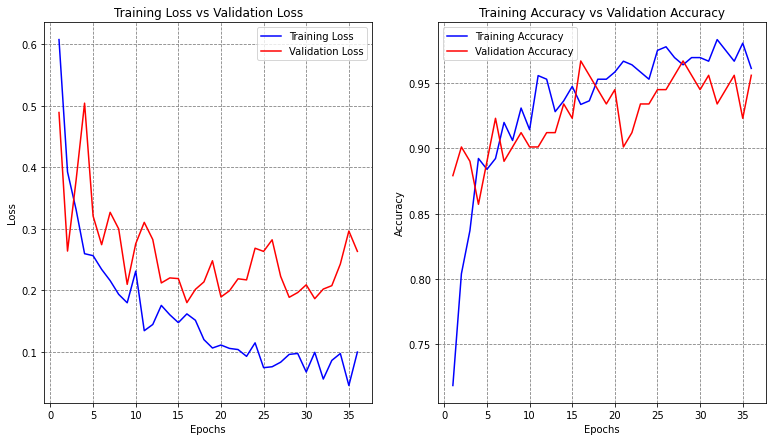

In [ ]:
model_type = 'US'
print('Build and save model')
model_history = create_model(train_data, train_labels, val_data, val_labels, SIZE, model_type)

## Evaluate CNN model

In [ ]:

path_jason_US = "/content/US_model.json"
path_model_US = "/content/US_model.h5"

In [ ]:
# Evaluate CNN model on validation and test data
model = load_cnn_model(path_jason_US, path_model_US)

# On validation data
y_true_val = val_labels
y_pred_val = model.predict(val_data)
y_pred_val = prob2binary(y_pred_val).ravel()
accuracy, precision, recall, specificity, f1, roc_auc = evaluate_performance(y_true_val, y_pred_val)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1 score:', f1)
print('ROC AUC:', roc_auc)


3/3 [==============================] - 2s 168ms/step
Accuracy: 0.9560439560439561
Precision: 0.9560439560439561
Recall: 0.9560439560439561
Specificity: 0.9534883720930233
F1 score: 0.9560439560439561
ROC AUC: 0.9559108527131784


In [ ]:
#On test data
y_true_test = test_labels
y_pred_test = model.predict(test_data)
y_pred_test = prob2binary(y_pred_test).ravel()
accuracy, precision, recall, specificity, f1, roc_auc = evaluate_performance(y_true_test, y_pred_test)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1 score:', f1)
print('ROC AUC:', roc_auc)

3/3 [==============================] - 1s 423ms/step
Accuracy: 0.8181818181818182
Precision: 0.8181818181818182
Recall: 0.8181818181818182
Specificity: 0.7714285714285715
F1 score: 0.8181818181818182
ROC AUC: 0.8211981566820277


## Feature Extraction

In [ ]:
# Load model
cnn_model_US = load_cnn_model(path_jason_US, path_model_US)
print("Loaded CNN US model from disk")

Loaded CNN US model from disk


In [ ]:
print("Extracting features from the Non Fused training data..........")
train_features_US =  get_feature_layer(cnn_model_US,train_data)

Extracting features from the Non Fused training data..........
12/12 [==============================] - 3s 146ms/step
Number of features extracted:  120


In [ ]:
print("Extracting features from the Non Fused validation data..........")
val_features_US =  get_feature_layer(cnn_model_US,val_data)

Extracting features from the Non Fused validation data..........
3/3 [==============================] - 2s 163ms/step
Number of features extracted:  120


In [ ]:
print("Extracting features from the test data..........")
test_features_US =  get_feature_layer(cnn_model_US,test_data)

Extracting features from the test data..........
3/3 [==============================] - 2s 168ms/step
Number of features extracted:  120


In [ ]:
print('Shape of train_features:', np.shape(train_features_US))

print('Shape of train_labels :', np.shape(train_labels))

print('Shape of val_features:', np.shape(val_features_US))

print('Shape of val_labels :', np.shape(val_labels))

print('Shape of test_features:', np.shape(test_features_US))

print('Shape of test_labels :', np.shape(test_labels))

Shape of train_features: (362, 120)
Shape of train_labels : (362,)
Shape of val_features: (91, 120)
Shape of val_labels : (91,)
Shape of test_features: (66, 120)
Shape of test_labels : (66,)


## Evaluation

In [ ]:
# Scores on validation data
scores_val = acc_score(train_features_US, val_features_US, train_labels, val_labels)

# Sorting by column 'F1_Score'
sorted_scores_val = scores_val.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results on non fused valdation dataset B ")
print("-----------------------------")
sorted_scores_val.head(10)

Results on non fused valdation dataset B 
-----------------------------


,Classifier,Accuracy,Precision,Recall,Sensitivity,Specificity,F1_Score,ROC_AUC
0,RandomForest,0.923077,0.976744,0.875000,0.875000,0.976744,0.923077,0.971415
1,AdaBoost,0.923077,0.976744,0.875000,0.875000,0.976744,0.923077,0.966085
2,KNeighbors,0.923077,0.976744,0.875000,0.875000,0.976744,0.923077,0.935562
3,Proposed,0.923077,0.976744,0.875000,0.875000,0.976744,0.923077,0.967054
4,DecisionTree,0.923077,1.000000,0.854167,0.854167,1.000000,0.921348,0.927083
5,MLP,0.912088,0.976190,0.854167,0.854167,0.976744,0.911111,0.970930
6,GradientBoosting,0.890110,0.931818,0.854167,0.854167,0.930233,0.891304,0.937742


In [ ]:
sorted_scores_val.to_csv("sorted_score_test_val.csv")

In [ ]:
# Scores on test data
scores_test = acc_score(train_features_US, test_features_US, train_labels, test_labels)

# Sorting by column 'F1_Score'
sorted_scores_test = scores_test.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results on non fused test dataset B ")
print("-----------------------------")
sorted_scores_test.head(10)

Results on non fused test dataset B 
-----------------------------


,Classifier,Accuracy,Precision,Recall,Sensitivity,Specificity,F1_Score,ROC_AUC
0,GradientBoosting,0.878788,0.870968,0.870968,0.870968,0.885714,0.870968,0.872811
1,RandomForest,0.848485,0.818182,0.870968,0.870968,0.828571,0.843750,0.946544
2,KNeighbors,0.848485,0.818182,0.870968,0.870968,0.828571,0.843750,0.884793
3,MLP,0.848485,0.818182,0.870968,0.870968,0.828571,0.843750,0.957604
4,Proposed,0.848485,0.818182,0.870968,0.870968,0.828571,0.843750,0.952995
5,AdaBoost,0.833333,0.794118,0.870968,0.870968,0.800000,0.830769,0.936406
6,DecisionTree,0.833333,0.794118,0.870968,0.870968,0.800000,0.830769,0.835484


In [ ]:
sorted_scores_test.to_csv("sorted_score_test_US.csv")

# Fused Dataset B

## Load Data

In [ ]:
# Load Training Data
X_fused, Y_fused = load_data(SIZE, path_fused)
print('Fused Dataset A loaded')
X_train_fused, X_test_fused, y_train_fused, y_test_fused = train_test_split(X_fused, Y_fused, test_size=0.3, random_state=42)

Fused Dataset A loaded


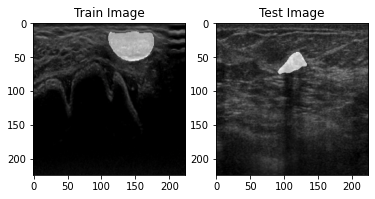

In [ ]:
#Visulaize the images
visualize(X_train_fused, X_test_fused)

In [ ]:
# Pre-process data
X_train_fused = normalize(X_train_fused, axis=1)
y_train_fused = one_hot_encode(y_train_fused)


test_data_fused = normalize(X_test_fused, axis=1)
test_labels_fused = one_hot_encode(y_test_fused)

In [ ]:
# Apply augmentation
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train_fused, y_train_fused)

# Combine the whole training data

fused_data = np.concatenate([X_train_fused, x_rotated, x_flipped])
fused_labels = np.concatenate([y_train_fused, y_rotated, y_flipped])

print('Shape of X_train:', np.shape(fused_data))
print('Shape of y_train:', np.shape(fused_labels))

Shape of X_train: (453, 224, 224, 3)
Shape of y_train: (453,)


In [ ]:
train_data_fused, val_data_fused, train_labels_fused, val_labels_fused = train_test_split(fused_data, fused_labels, test_size=0.2, random_state=42)

In [ ]:
print('Shape of training data:', np.shape(train_data_fused))
print('Shape of training labels:', np.shape(train_labels_fused))

print('Shape of validation data:', np.shape(val_data_fused))
print('Shape of validation labels:', np.shape(val_labels_fused))

print('Shape of test data:', np.shape(test_data_fused))
print('Shape of test labels:', np.shape(test_labels_fused))

Shape of training data: (362, 224, 224, 3)
Shape of training labels: (362,)
Shape of validation data: (91, 224, 224, 3)
Shape of validation labels: (91,)
Shape of test data: (66, 224, 224, 3)
Shape of test labels: (66,)


## Train Model

In [ ]:
model_type = 'fused'
print('Build and save model')
model_history = create_model(train_data_fused, train_labels_fused, val_data_fused, val_labels_fused, SIZE, model_type)

### Evaluate CNN model

In [ ]:
path_jason_fused = "/content/fused_model.json"
path_model_fused = "/content/fused_model.h5"

In [ ]:
# Evaluate CNN model on validation and test data
model = load_cnn_model(path_jason_fused, path_model_fused)

# On validation data
y_true_val = val_labels_fused
y_pred_val = model.predict(val_data_fused)
y_pred_val = prob2binary(y_pred_val).ravel()
accuracy, precision, recall, specificity, f1, roc_auc = evaluate_performance(y_true_val, y_pred_val)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1 score:', f1)
print('ROC AUC:', roc_auc)

3/3 [==============================] - 2s 176ms/step
Accuracy: 0.978021978021978
Precision: 0.978021978021978
Recall: 0.978021978021978
Specificity: 0.9583333333333334
F1 score: 0.978021978021978
ROC AUC: 0.9791666666666667


In [ ]:
#On test data
y_true_test = test_labels_fused
y_pred_test = model.predict(test_data_fused)
y_pred_test = prob2binary(y_pred_test).ravel()
accuracy, precision, recall, specificity, f1, roc_auc = evaluate_performance(y_true_test, y_pred_test)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1 score:', f1)
print('ROC AUC:', roc_auc)

3/3 [==============================] - 0s 169ms/step
Accuracy: 0.803030303030303
Precision: 0.803030303030303
Recall: 0.803030303030303
Specificity: 0.6875
F1 score: 0.803030303030303
ROC AUC: 0.7996323529411764


## Feature Extraction

In [ ]:
# Load model
cnn_model_fused = load_cnn_model(path_jason_fused, path_model_fused)
print("Loaded CNN fused model from disk")

Loaded CNN fused model from disk


In [ ]:
print("Extracting features from the Fused training data..........")
train_features_fused =  get_feature_layer(cnn_model_fused,train_data_fused)

Extracting features from the Fused training data..........
12/12 [==============================] - 3s 153ms/step
Number of features extracted:  120


In [ ]:
print("Extracting features from the Fused validation data..........")
val_features_fused =  get_feature_layer(cnn_model_fused,val_data_fused)

Extracting features from the Fused validation data..........
3/3 [==============================] - 2s 179ms/step
Number of features extracted:  120


In [ ]:
print("Extracting features from the test data..........")
test_features_fused =  get_feature_layer(cnn_model_fused,test_data_fused)

Extracting features from the test data..........
3/3 [==============================] - 2s 164ms/step
Number of features extracted:  120


In [ ]:
print('Shape of train_features:', np.shape(train_features_fused))

print('Shape of train_labels :', np.shape(train_labels_fused))

print('Shape of val_features:', np.shape(val_features_fused))

print('Shape of val_labels :', np.shape(val_labels_fused))

print('Shape of test_features:', np.shape(test_features_fused))

print('Shape of test_labels :', np.shape(test_labels_fused))

Shape of train_features: (362, 120)
Shape of train_labels : (362,)
Shape of val_features: (91, 120)
Shape of val_labels : (91,)
Shape of test_features: (66, 120)
Shape of test_labels : (66,)


## Evaluation

In [ ]:
# Scores on validation data
scores_val_fused = acc_score(train_features_fused, val_features_fused, train_labels_fused, val_labels_fused)

# Sorting by column 'F1_Score'
sorted_scores_val_fused = scores_val_fused.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results on fused valdation dataset B")
print("-----------------------------")
sorted_scores_val_fused.head(10)

Results on fused valdation dataset A 
-----------------------------


,Classifier,Accuracy,Precision,Recall,Sensitivity,Specificity,F1_Score,ROC_AUC
0,RandomForest,0.978022,0.955556,1.000000,1.000000,0.958333,0.977273,0.999031
1,AdaBoost,0.978022,0.955556,1.000000,1.000000,0.958333,0.977273,0.987888
2,KNeighbors,0.978022,0.955556,1.000000,1.000000,0.958333,0.977273,0.989341
3,MLP,0.978022,0.955556,1.000000,1.000000,0.958333,0.977273,0.997578
4,Proposed,0.967033,0.934783,1.000000,1.000000,0.937500,0.966292,0.998547
5,DecisionTree,0.956044,0.933333,0.976744,0.976744,0.937500,0.954545,0.957122
6,GradientBoosting,0.956044,0.933333,0.976744,0.976744,0.937500,0.954545,0.957122


In [ ]:
sorted_scores_val_fused.to_csv("sorted_score_test_val_fused.csv")

In [ ]:
# Scores on test data
scores_test_fused = acc_score(train_features_fused, test_features_fused, train_labels_fused, test_labels_fused)

# Sorting by column 'F1_Score'
sorted_scores_test_fused = scores_test_fused.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results on fused test dataset B ")
print("-----------------------------")
sorted_scores_test_fused.head(10)

Results on fused test dataset A 
-----------------------------


,Classifier,Accuracy,Precision,Recall,Sensitivity,Specificity,F1_Score,ROC_AUC
0,RandomForest,0.848485,0.815789,0.911765,0.911765,0.78125,0.861111,0.907629
1,KNeighbors,0.848485,0.852941,0.852941,0.852941,0.84375,0.852941,0.905331
2,AdaBoost,0.833333,0.828571,0.852941,0.852941,0.81250,0.840580,0.921875
3,Proposed,0.818182,0.789474,0.882353,0.882353,0.75000,0.833333,0.914522
4,MLP,0.803030,0.769231,0.882353,0.882353,0.71875,0.821918,0.919118
5,DecisionTree,0.803030,0.783784,0.852941,0.852941,0.75000,0.816901,0.801471
6,GradientBoosting,0.803030,0.783784,0.852941,0.852941,0.75000,0.816901,0.801471


In [ ]:
sorted_scores_test_fused.to_csv("sorted_score_test_fused.csv")

# Genetic Algorithm

## Genetic ALgorithm Functions

In [ ]:
!pip install tqdm

In [ ]:
## Genetic ALgorithm Functions

import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from tqdm import tqdm
# Constants
POPULATION_SIZE = 30
MAX_GENERATIONS = 50

def initialize_population(num_features, population_size):
    population = []
    for _ in range(population_size):
        solution = random.sample(range(num_features), random.randint(1, num_features))
        population.append(solution)
    return population


def roulette_wheel_selection(population, fitnesses):
    # Normalize fitness values
    total_fitness = sum(fitnesses)
    normalized_fitnesses = [f/total_fitness for f in fitnesses]

    # Generate roulette wheel
    wheel = []
    current_position = 0
    for f in normalized_fitnesses:
        current_position += f
        wheel.append(current_position)

    # Select parents
    parents = []
    for i in range(len(population)):
        r = random.random()
        for j, w in enumerate(wheel):
            if r <= w:
                parents.append(population[j])
                break

    return parents


def two_point_crossover(parent1, parent2):
    # Choose crossover points
    point1 = random.randint(0, len(parent1))
    point2 = random.randint(point1, len(parent1))

    # Create offspring
    child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
    child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]

    return child1, child2



def mutate(solution, num_features, mutation_rate):
    # Determine whether to add or remove a feature
    if random.random() < mutation_rate:
        # Add a random feature
        solution.append(random.randint(0, num_features-1))
    elif len(solution) > 1:
        # Remove a random feature
        solution.remove(random.choice(solution))
    return solution



def select_fittest(population, fitnesses):
    # Sort population and fitnesses by fitness values
    population_fitnesses = list(zip(population, fitnesses))
    population_fitnesses.sort(key=lambda x: x[1], reverse=True)
    sorted_population, sorted_fitnesses = zip(*population_fitnesses)

    # # Return sorted population up to the maximum size
    return sorted_population[:POPULATION_SIZE]


def evaluate_fitness(population):
    fitnesses = []
    for solution in population:
        model = RandomForestClassifier()
        scores = cross_validate(model, X[:, solution], y, cv=5, scoring='f1_macro')
        fitnesses.append(scores['test_score'].mean())
    return fitnesses


def optimize_feature_subset(X, y):
    # Initialize population
    population = initialize_population(X.shape[1], POPULATION_SIZE)
    fitnesses = evaluate_fitness(population)
    all_fitnesses = [fitnesses] # store fitness values in all generations

    previous_max_fitness = -float("inf") # minimum possible fitness value
    no_progress_count = 0 # counter for number of generations with no progress

    for generation in tqdm(range(MAX_GENERATIONS)):
        #print(f"Generation {generation}: population size = {len(population)}, fitnesses size = {len(fitnesses)}")
        #print(f"Population: {population}")
        #print(f"Fitnesses: {fitnesses}")

        # Select fittest solutions for next generation
        population = select_fittest(population, fitnesses)

        # Generate offspring through crossover and mutation
        offspring = []
        for _ in range(len(population)//2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = two_point_crossover(parent1, parent2)
            child1 = mutate(child1, X.shape[1], 1/X.shape[1])
            child2 = mutate(child2, X.shape[1], 1/X.shape[1])
            offspring.extend([child1, child2])

        # Evaluate fitness of offspring
        offspring_fitnesses = evaluate_fitness(offspring)

        # Select fittest solutions for next generation
        population = select_fittest(list(population) + offspring, fitnesses + offspring_fitnesses)


        # Evaluate fitness of current population
        fitnesses = evaluate_fitness(population)
        all_fitnesses.append(fitnesses)

        # Check for progress
        current_max_fitness = max(fitnesses)
        if current_max_fitness <= previous_max_fitness:
            no_progress_count += 1
        else:
            no_progress_count = 0
            previous_max_fitness = current_max_fitness

        # Terminate if no progress for 5 generations
        if no_progress_count >= 5:
            break

    # Return fittest solution
    fittest_index = fitnesses.index(max(fitnesses))
    return population[fittest_index]

## Call Genetic ALgorithm

In [ ]:
# Select top features for train data
# Define X and y
X = train_features_fused
y = train_labels_fused
optimized_feature_subset = optimize_feature_subset(train_features_fused, train_labels_fused)

In [ ]:
# Select top features for train data
X_train_top = train_features_fused[:, optimized_feature_subset]

# Select top features for valdation data
X_val_top = val_features_fused[:, optimized_feature_subset]

# Select top features for test data
X_test_top = test_features_fused[:, optimized_feature_subset]

In [ ]:
print('Shape of train_features:', np.shape(X_train_top))

print('Shape of train_labels :', np.shape(train_labels_fused))

print('Shape of val_features:', np.shape(X_val_top))

print('Shape of val_labels :', np.shape(val_labels_fused))

print('Shape of test_features:', np.shape(X_test_top))

print('Shape of test_labels :', np.shape(test_labels_fused))

In [ ]:
# Scores on validation data
ga2_scores_val_fused = acc_score(X_train_top, X_val_top, train_labels_fused, val_labels_fused)

# Sorting by column 'F1_Score'
ga2_sorted_scores_val_fused = ga2_scores_val_fused.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results after GA on fused valdation dataset A ")
print("-----------------------------")
ga2_sorted_scores_val_fused.head(10)

In [ ]:
# Scores on test data
ga2_scores_test_fused = acc_score(X_train_top, X_test_top, train_labels_fused, test_labels_fused)

# Sorting by column 'F1_Score'
ga2_sorted_scores_test_fused = ga2_scores_test_fused.sort_values(by=['F1_Score'], ascending=False)

In [ ]:
print("Results Results after GA on fused test dataset A ")
print("-----------------------------")
ga2_sorted_scores_test_fused.head(10)